In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import quantecon as qe
from numba import jit
from scipy.optimize import brentq

In [2]:
#parameters

mu = 0.34
eta = 0.01
beta = 0.99
theta = 0.36
delta = 0.025
rho = 0.9
sigma = 2
nz = 5

In [3]:
#this is where we developed the Markov process
"""#get the probabilities from the Markov process

#move this inside the Ramsey_Econ602 class

z_list = []
for i in list(range(1,nz+1)):
    z_list.append(f"z_{i}")

#this is the transition matrix. the rows are current states, and the columns are next period's states.
#interpretation: the ij entry is the probability of being in state i in the current period and going state to j next period 
#this makes sense because the ij entry where i=j is always the highest (probability of staying in the same state)
trans_matrix = pd.DataFrame(qe.markov.tauchen(rho, sigma, 0, eta, nz).P,
                     columns = z_list,
                     index = z_list)
print(trans_matrix.round(6))

#this gives us the states values of each z_i
state_values = pd.DataFrame(qe.markov.tauchen(rho, sigma, 0, eta, nz).state_values,
                            index = z_list,
                            columns = ['z_state_values'])
print(state_values)"""

          z_1       z_2       z_3       z_4       z_5
z_1  0.501373  0.004576  0.004575  0.004574  0.484902
z_2  0.497254  0.004576  0.004576  0.004575  0.489019
z_3  0.493136  0.004576  0.004576  0.004576  0.493136
z_4  0.489019  0.004575  0.004576  0.004576  0.497254
z_5  0.484902  0.004574  0.004575  0.004576  0.501373
     z_state_values
z_1       -0.045883
z_2       -0.022942
z_3        0.000000
z_4        0.022942
z_5        0.045883


In [4]:
#this is where we figured out brentq
"""#solve leisure
#this will need to go inside a loop to solve leisure inside the Ramsey_Econ602 class
def l(kz):
    return brentq(lambda x: (x**(1-theta))*((1-mu)/mu+1-theta-(1-theta)/x)-kz, 0.00001, 1)


#brentq finds a zero of a nonlinear function. the formula in l(kz) uses kz = LHS from slide 7 and subtracts it from the RHS
#that is, kz = ((k'-(1-delta)k)/(zk^theta))"""

Basically we're idiots. We can't solve the steady state deterministically like we tried because z is stochastic. Slide 3 was if z = 1 always, but our z is random. Instead, we need to use Markov to find possible values and combine that with k (slide 7 formula) to find utility u(c,l). That is, we don't need to alter the code to include l; rather, we should alter it only to solve k with the possible values of z and the given parameters of our proble. 

Cleaned the leisure stuff out of the ramsey function and put it into the returns function

In [5]:
#this is the hw2_ex_v3 code from Rajesh--edit to fit our needs

class Ramsey_Econ602:

    def __init__(self,
                 mu,
                 sigma,
                 beta,
                 theta,
                 delta,
                 rho,
                 eta,
                 nk=100,
                 nz=5,
                 tol=1e-10,
                 maxit=10000):

        # Save parameters
        self.mu = mu
        self.sigma = sigma
        self.beta = beta
        self.theta = theta
        self.delta = delta
        self.rho = rho
        self.eta = eta
        self.nk = nk
        self.nz = nz
        
        # get the state values and transition matrix from the markov chain for z
        self.markov_chain = qe.markov.tauchen(rho, sigma, 0, eta, nz)
        self.z_state_values = np.exp(self.markov_chain.state_values) #the formula we're given is ln(z) = ln(z_{-1}) + epsilon_i
        self.transition_matrix = self.markov_chain.P
                        
        #steady state k and l (capital and leisure)
        #these are just to approximate bounds for a linear space that we'll iterate over
        self.ls = (1-theta)/(((1-mu)/mu)+1-theta-((delta*theta)/(1/beta-(1-delta))))
        self.ks = self.ls*((1/beta-(1-delta))/theta)**(1/theta-1)
        
        #need self.kgrid and zgrid because k and z are our state variables
        self.kgrid = np.linspace(0.5*self.ks, 2*self.ks, nk)
        self.zgrid = self.z_state_values

        # Allocate memory--essentially we're just pre-defining the shape of objects we'll pass into functions to fill later
        self.v = np.zeros((nz,nk)) #initial guess for Bellman is zeros
        self.gk_index = np.empty((nz,nk))
        self.gpr = np.empty((nz,nk))
        self.Ret = np.zeros((nz,nk,nk))
        self.l = np.empty((nz,nk,nk))
        
        #here's where we need to solve for leisure
        
        def l_solver(kz):
            return brentq(lambda x: (x**(1-theta))*((1-mu)/mu+1-theta-(1-theta)/x)-kz, 0.00001, 1)
        
        for z_i in range(nz):
            for k_i in range(nk):
                for k_prime_i in range(nk):
                    #LHS of labor-leisure on slide 3. we use this to solve for leisure using brentq
                    LHS = (self.kgrid[k_prime_i]-(1-delta)*self.kgrid[k_i])/(self.zgrid[z_i]*self.kgrid[k_i]**theta)
                    if LHS >= (1-mu)/mu:
                        self.l[z_i, k_i, k_prime_i] = 1
                    else:
                        self.l[z_i, k_i, k_prime_i] = l_solver(LHS)
        
        # compute the return function
        _compute_returns(self.kgrid,self.zgrid,self.delta,self.theta,self.mu,self.sigma,self.l,self.Ret)
                
        # Compute the value function and policy function
        self.solve(tol=tol, maxit=maxit)
        self.kpr_policy()
   
    # solve is the actual value function iteration
    def solve(self, tol=1e-9, maxit=10000):
        # Iteration Stuff
        it = 0
        dist = 10.

        # Allocate memory to store next iterate of value function
        v_upd = np.zeros((self.nz,self.nk))
        
        # Main loop
        while dist > tol and maxit > it:
            
            self.E_v = np.matmul(self.transition_matrix, self.v)
            
            _inner_loop(self.Ret,self.v,self.E_v,self.beta,self.zgrid,self.kgrid)
            
            dist = np.max(np.abs(v_upd - self.v))
            v_upd[:] = self.v[:]

            it += 1
            if it % 25 == 0:
                print(f"Running iteration {it} with dist of {dist}")

        return None    
        
    # This is to recover policy function after the value function has converged
    
    def kpr_policy(self):
    
    # Compute gpr and its index: best index in kgrid given ik  
        self.gpr = np.empty((self.nz,self.nk))

        _compute_savings_policy(self.kgrid, self.zgrid, self.Ret, self.v, self.E_v, self.beta, self.gpr)

# Just to compute utility--need to solve for leisure before this can work        
@jit(nopython=True)
def u(c, l, mu, sigma):
    return (1/(1-sigma))*((c**mu)*((1-l)**(1-mu)))**(1-sigma)

#this will have an nz loop added
#we need to get the expected value of the bellman by multiplying v(z',k') with the corresponding value in the transition matrix
@jit(nopython=True)
def _inner_loop(Ret,v,E_v,beta,zgrid,kgrid):
    
    """
    This is a numba version of the inner loop of the solve in the
    Ramsey class. It updates v in place.
    """
    for z_i in range(len(zgrid)):
        for k_i in range(len(kgrid)):
            current_max = -1e14
            for k_prime_i in range(len(kgrid)):
                # m is the Bellman: Ret is utility, and E_v is expected bellman
                m = Ret[z_i,k_i,k_prime_i] + beta * E_v[z_i,k_prime_i]

                if m > current_max:
                    current_max = m      

                v[z_i,k_i] = current_max  
            
    return None

#this will have an nz loop added too
#need the expected value of the Bellman here too
@jit(nopython=True)
def _compute_savings_policy(kgrid,zgrid,Ret,v,E_v,beta,gpr):
    for z_i in range(len(zgrid)):
        for k_i in range(len(kgrid)):
            current_max = -1e14
            for k_prime_i in range(len(kgrid)):
                m = Ret[z_i,k_i,k_prime_i] + beta * E_v[z_i,k_prime_i]
                if m > current_max:
                    current_max = m
                    current_max_index = k_prime_i
                gpr[z_i,k_i] = kgrid[current_max_index]
    return None 

#this will have an nz loop added too
@jit(nopython=True)
def _compute_returns(kgrid,zgrid,delta,theta,mu,sigma,l,Ret):
    for z_i in range(len(zgrid)):
        for k_i in range(len(kgrid)):
            for k_prime_i in range(len(kgrid)):
                #l_i is just the number corresponding to the z_i, k_i, k_prime_i position in the l matrix
                l_i = l[z_i,k_i,k_prime_i]
                if l_i == 1:
                    Ret[z_i,k_i,k_prime_i] = -1e+14
                else:
                    c = zgrid[z_i]*(kgrid[k_i]**theta)*(l_i**(1-theta))-kgrid[k_prime_i]+(1-delta)*kgrid[k_i]
                    if c <= 0:
                        Ret[z_i,k_i,k_prime_i] = -1e+14
                    else: 
                        Ret[z_i,k_i,k_prime_i] = u(c, l_i, mu, sigma)
    return None

In [8]:
ramsey = Ramsey_Econ602(mu,
                sigma,
                beta,
                theta,
                delta,
                rho,
                eta,
                nk=100,
                nz=5,
                tol=1e-10,
                maxit=10000)

Running iteration 25 with dist of 2.296339205403001
Running iteration 50 with dist of 1.78614168238812
Running iteration 75 with dist of 1.3892991514746313
Running iteration 100 with dist of 1.0806265546120812
Running iteration 125 with dist of 0.8405344157111756
Running iteration 150 with dist of 0.6537856218502327
Running iteration 175 with dist of 0.5085284211431826
Running iteration 200 with dist of 0.3955442678266934
Running iteration 225 with dist of 0.30766278010355563
Running iteration 250 with dist of 0.23930668185664672
Running iteration 275 with dist of 0.18613784859508087
Running iteration 300 with dist of 0.14478199442987716
Running iteration 325 with dist of 0.11261452772396296
Running iteration 350 with dist of 0.0875939850423606
Running iteration 375 with dist of 0.06813247252080146
Running iteration 400 with dist of 0.05299489239541799
Running iteration 425 with dist of 0.04122055924426604
Running iteration 450 with dist of 0.03206223142649378
Running iteration 475 wit

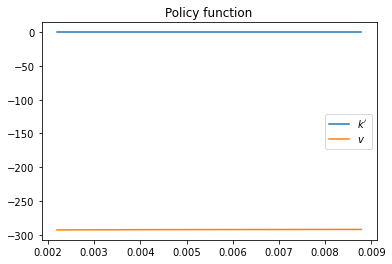

In [26]:
#need these to be 3d
fig, ax = plt.subplots()
ax.set_title("Policy function")

    
ax.plot(ramsey.kgrid, ramsey.gpr[0], label="$k'$")
ax.legend()

ax.plot(ramsey.kgrid, ramsey.v[1], label="$v$")
ax.legend()
plt.show()